In [1]:
import ipywidgets as widgets
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
#from scipy.stats import norm, t
import matplotlib.pyplot as plt
import json
import decimal
decimal.getcontext().prec = 4
import multiprocessing
from joblib import Parallel, delayed
import io
from scipy.special import btdtri
from tabulate import tabulate

def printmd(string, color='red'):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))


def upload_file():
    printmd('**Upload the .csv data file with control/treatment in first column and binary observations in second column:**')
    uploader = widgets.FileUpload(accept = '.csv', multiple = False)
    display(uploader)
    return uploader   
    
    
def read_file(uploader):
    input_file = list(uploader.value.values())[0]
    content = input_file['content']
    content = io.StringIO(content.decode('utf-8'))
    df = pd.read_csv(content)
    return df

def do_classical_test(df, level_of_sig):
    str1 = df.columns[0]  ## column name of variations
    str2 = df.columns[1]  ## column name of observations
    
    variation1_name = df[str1].unique()[0] ## name of variation 1
    variation2_name = df[str1].unique()[1] ## name of variation 2
    
    dataset1 = df[df[str1] == variation1_name]
    dataset2 = df[df[str1] == variation2_name]
    
    ci_dataset1 = np.sqrt(dataset1[str2].mean()*(1 - dataset1[str2].mean())/len(dataset1[str2]))*ss.norm.ppf(1-level_of_sig/2)
    ci_dataset2 = np.sqrt(dataset1[str2].mean()*(1 - dataset1[str2].mean())/len(dataset2[str2]))*ss.norm.ppf(1-level_of_sig/2 )
    
    p1 = plt.bar(0, dataset1[str2].mean(), color = 'red', edgecolor = 'black', yerr = ci_dataset1, capsize = 15, label = variation1_name, width = 0.2)
    p2 = plt.bar(0.4, dataset2[str2].mean(), color = 'green', edgecolor = 'black', yerr = ci_dataset2, capsize = 15, label = variation2_name, width = 0.2)
    
    plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks([0, 0.4], [variation1_name, variation2_name])
    plt.show()
    
    t_stat, p_val = ss.ttest_ind(dataset1[str2], dataset2[str2])
    
    if t_stat<=0 and p_val <= level_of_sig:
        printmd(f'**The variation \'{variation2_name}\' has significantly higher conversion rate compared to the the \'{variation1_name}\'. The p value of the test is {p_val:.5f}.**', color = 'green')
        
    if t_stat>=0 and p_val <= level_of_sig:
        printmd(f'**The variation \'{variation1_name}\' has significantly higher conversion rate compared to the \'{variation2_name}\'. The p value of the test is {p_val:.5f}.**', color = 'red')
        
    if p_val > level_of_sig:
        printmd(f'**The test is inconclusive. P-value is {p_val: .5f}.**')
    #return t_stat, p_val
    

def calculate_expected_loss(control_simulation, treatment_simulation, treatment_won, min_difference_delta=0):
    control_simulation = np.array(control_simulation)
    treatment_simulation = np.array(treatment_simulation)
    
    loss_control = (treatment_simulation - min_difference_delta) - control_simulation
    loss_treatment = (control_simulation - min_difference_delta) - treatment_simulation
    
    all_loss_control = treatment_won * loss_control
    all_loss_treatment = (1 - treatment_won) * loss_treatment
    
    return np.mean(all_loss_control), np.mean(all_loss_treatment)


    
def do_bayesian_test2(df, eps):
    str1 = df.columns[0]
    str2 = df.columns[1]
    
    variation1_name = df[str1].unique()[0]
    variation2_name = df[str1].unique()[1]
    
    if len(df[df[str1] == variation1_name]) < len(df[df[str1] == variation2_name]):
        variation1_name = df[str1].unique()[1]
        variation2_name = df[str1].unique()[0]
        
    dataset1 = df[df[str1] == variation1_name]
    dataset2 = df[df[str1] == variation2_name]
    
    variation1_data = np.array(dataset1[str2])
    variation2_data = np.array(dataset2[str2])
    variation1_conversions = sum(variation1_data)
    variation2_conversions = sum(variation2_data)
    variation1_sample_size = len(variation1_data)
    variation2_sample_size = len(variation2_data)
    
    variation1_expected_cr = variation1_data.mean() ##to be reported
    variation2_expected_cr = variation2_data.mean() ##to be reported
    variation1_cr_lci = btdtri(1+variation1_conversions, 1+variation1_sample_size - variation1_conversions, 0.025)
    variation1_cr_uci = btdtri(1+variation1_conversions, 1+variation1_sample_size - variation1_conversions, 0.975)
    variation2_cr_lci = btdtri(1+variation2_conversions, 1+variation2_sample_size - variation2_conversions, 0.025)
    variation2_cr_uci = btdtri(1+variation2_conversions, 1+variation2_sample_size - variation2_conversions, 0.975)
    
    
    
    variation1_cr_samples = np.random.beta(1+variation1_conversions, 1+variation1_sample_size-variation1_conversions, size=700000)
    variation2_cr_samples = np.random.beta(1+variation2_conversions, 1+variation2_sample_size-variation2_conversions, size=700000)
    variation1_prob_beat = (variation1_cr_samples >= variation2_cr_samples).astype(int).mean() ## to be reported
    variation2_prob_beat = (variation2_cr_samples >= variation1_cr_samples).astype(int).mean() ##to be reported
    variation1_lift = ((variation1_cr_samples - variation2_cr_samples)/variation2_cr_samples) 
    variation2_lift = ((variation2_cr_samples - variation1_cr_samples)/variation1_cr_samples) 
    variation1_exp_lift = variation1_lift.mean() ##to be reported
    variation2_exp_lift = variation2_lift.mean() ##to be reported
    variation1_exp_lift_interval = np.quantile(variation1_lift, [0.025, 0.975], axis = 0)
    variation2_exp_lift_interval = np.quantile(variation2_lift, [0.025, 0.975], axis = 0)
    
    report_table = tabulate([['Variation name', 'Expected conversion', 'Probability to beat other', 'Expected improvement over other', 'C.I. for improvement'],
                   [f'{variation1_name}', f'{variation1_expected_cr*100:.3f}%', f'{variation1_prob_beat*100:.3f}%', f'{variation1_exp_lift*100:.3f}%', f'[{variation1_exp_lift_interval[0]*100:.3f}%, {variation1_exp_lift_interval[1]*100:.3f}%]'],
                   [f'{variation2_name}', f'{variation2_expected_cr*100:.3f}%', f'{variation2_prob_beat*100:.3f}%', f'{variation2_exp_lift*100:.3f}%', f'[{variation2_exp_lift_interval[0]*100:.3f}%, {variation2_exp_lift_interval[1]*100:.3f}%]']])
    
    variation2_won = (variation2_cr_samples >= variation1_cr_samples).astype(int)
    variation1_exp_loss, variation2_exp_loss = calculate_expected_loss(variation1_cr_samples, variation2_cr_samples, variation2_won)
    if variation1_exp_loss<=eps and variation1_prob_beat>=0.9:
        result = f'{variation1_name} is the winner. Expect a relative improvement of {variation1_exp_lift*100:.3f}% over {variation2_name}.'
    elif variation2_exp_loss<=eps and variation2_prob_beat>=0.9:
        result = f'{variation2_name} is the winner. Expect a relative improvement of {variation2_exp_lift*100:.3f}% over {variation1_name}.'
    else:
        result = f'There is not enough confidence in declaring a winner.'
    
    print(report_table)
    printmd(f'**{result}**', color = 'black')
    
    ### posterior plots
    leftlim = min(min(variation1_expected_cr, variation2_expected_cr) - 2*abs(variation1_expected_cr - variation2_expected_cr), min(variation1_cr_lci, variation2_cr_lci))
    rightlim = max(max(variation1_expected_cr, variation2_expected_cr) + 2*abs(variation1_expected_cr - variation2_expected_cr), max(variation1_cr_uci, variation2_cr_uci))
    x_axis = np.arange(leftlim, rightlim, 0.0001)
    posterior_plot, ax = plt.subplots(1)
    plt.plot(x_axis, ss.beta.pdf(x_axis, 1+variation1_conversions, 1+variation1_sample_size - variation1_conversions), color = 'r', label = variation1_name)
    plt.plot(x_axis, ss.beta.pdf(x_axis, 1+variation2_conversions, 1+variation2_sample_size - variation2_conversions), color = 'g', label = variation2_name)
    plt.axvspan(variation1_cr_lci, variation1_cr_uci, alpha = 0.3, color = 'red')
    plt.axvspan(variation2_cr_lci, variation2_cr_uci, alpha = 0.3, color = 'green')
    plt.axvline(x = variation1_expected_cr, color = 'red', linestyle = ':')
    plt.axvline(x = variation2_expected_cr, color = 'green', linestyle = ':')
    plt.legend()
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('Posterior Density')
    ax.set_xlabel('Conversion rates')
    plt.title('Conversion rates with shaded 95% credible intervals')


In [2]:
style = {'description_width': 'initial'}
def do_test(df, level_of_sig, epsilon, string):
    if string == 'Classical':
        do_classical_test(df, level_of_sig)
        
    if string == 'Bayesian':
        do_bayesian_test2(df, epsilon)
    
method_choice = widgets.Select(
                options = ['Classical', 'Bayesian'],
                value = 'Classical',
                description = f'<b>Method</b>',
                style = style
)

level_of_sig = widgets.BoundedFloatText(
                value = 0.05,
                min = 0.01,
                max = 0.1,
                #step = 0.01,
                description = f'<b>Level of Significance</b>',
                readout_format = '.4f',
                style = style
)

epsilon = widgets.BoundedFloatText(
        value = 0.001,
        min = 0.0000001,
        max = 0.1,
        #step = eps_min,
        description = f'<b>Expected Loss Threshold</b>',
        #readout = False,
        style = style
)
#eps_label = widgets.Label()
#eps_box = widgets.HBox([epsilon, eps_label])
#mylink = widgets.jslink((epsilon, 'value'), (eps_label, 'value'))

def threshold_display(arr):
    if arr == 'Classical':
        printmd('**Enter Level of Significance for Classical calculation:**')
        display(level_of_sig)
            
    if arr == 'Bayesian':
        printmd('**Enter expected loss threshold:**')
        display(epsilon)

In [9]:
up = upload_file()

<span style='color:red'>**Upload the .csv data file with control/treatment in first column and binary observations in second column:**</span>

FileUpload(value={}, accept='.csv', description='Upload')

In [10]:
df = read_file(up)
printmd('**Choose preferred method for the test.**'); display(method_choice)

<span style='color:red'>**Choose preferred method for the test.**</span>

Select(description='<b>Method</b>', index=1, options=('Classical', 'Bayesian'), style=DescriptionStyle(descrip…

In [11]:
threshold_display(method_choice.value)

<span style='color:red'>**Enter expected loss threshold:**</span>

BoundedFloatText(value=0.0004, description='<b>Expected Loss Threshold</b>', max=0.1, min=1e-07, style=Descrip…

--------------  -------------------  -------------------------  -------------------------------  --------------------
Variation name  Expected conversion  Probability to beat other  Expected improvement over other  C.I. for improvement
control         20.000%              0.278%                     -4.745%                          [-7.991%, -1.411%]
trt             21.000%              99.722%                    5.014%                           [1.431%, 8.685%]
--------------  -------------------  -------------------------  -------------------------------  --------------------


<span style='color:black'>**trt is the winner. Expect a relative improvement of 5.014% over control.**</span>

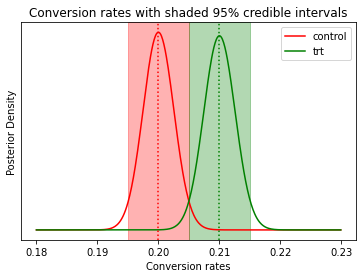

In [12]:
do_test(df, level_of_sig.value, epsilon.value, method_choice.value)

In [ ]:
## display data sample
## suggest threshold